In [1]:
# 📁 Step 1: Upload ZIP Dataset File Manually
from google.colab import files
uploaded = files.upload()


Saving spam_sms.zip to spam_sms.zip


In [2]:
# 📂 Step 2: Extract ZIP File
import zipfile
import os

for fname in uploaded.keys():
    if fname.endswith('.zip'):
        with zipfile.ZipFile(fname, 'r') as zip_ref:
            zip_ref.extractall("spam_sms")


In [3]:
# 📊 Step 3: Load Dataset CSV (Update filename if needed)
import pandas as pd

file_path = "spam_sms/spam.csv"  # ✅ Update this filename if needed
df = pd.read_csv(file_path, encoding='latin-1')
df = df.rename(columns={df.columns[0]: "label", df.columns[1]: "message"})
df = df[["label", "message"]]
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# 📈 Step 4: Explore Data Structure
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
       label                 message
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30
label      0
message    0
dtype: int64


In [5]:
# 🔤 Step 5: Encode Label Column (spam/ham)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label_num'] = label_encoder.fit_transform(df['label'])  # spam=1, ham=0


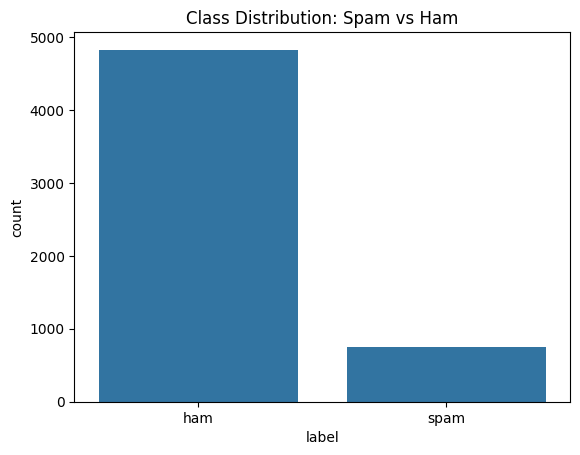

In [6]:
# 📊 Step 6: Visualize Class Distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=df)
plt.title("Class Distribution: Spam vs Ham")
plt.show()


In [7]:
# ✂️ Step 7: Text Preprocessing
import re
import string

def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df['clean_message'] = df['message'].apply(preprocess_text)


In [9]:

# 📚 Step 8: Vectorize Text Data
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['clean_message'])
y = df['label_num']


In [10]:
# 📌 Step 9: Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [11]:
# 🤖 Step 10: Train Model (Naive Bayes)
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

In [12]:

# 🧮 Step 11: Evaluate Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy: 0.9617224880382775

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1453
           1       1.00      0.71      0.83       219

    accuracy                           0.96      1672
   macro avg       0.98      0.85      0.90      1672
weighted avg       0.96      0.96      0.96      1672


📉 Confusion Matrix:
 [[1453    0]
 [  64  155]]


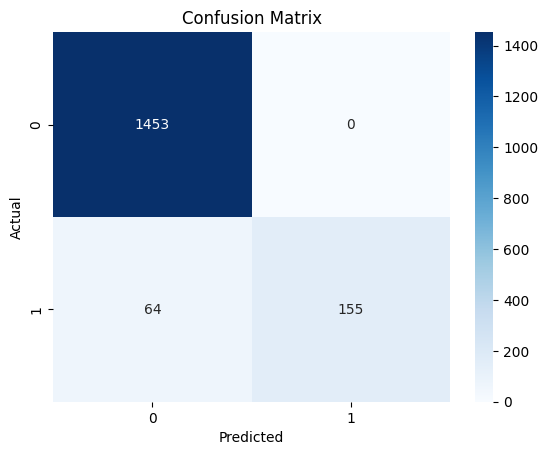

In [13]:
# 📈 Step 12: Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

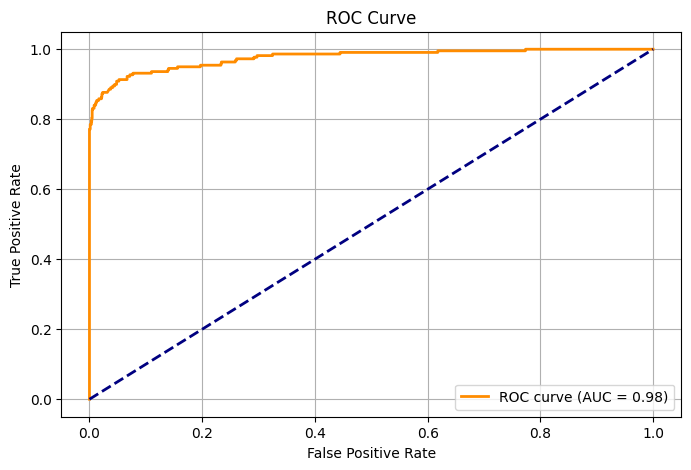

In [14]:
# 📈 Step 13: ROC Curve
from sklearn.metrics import roc_curve, auc

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


<ipython-input-16-ba1c56b3a92b>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_feature_names, palette="viridis")


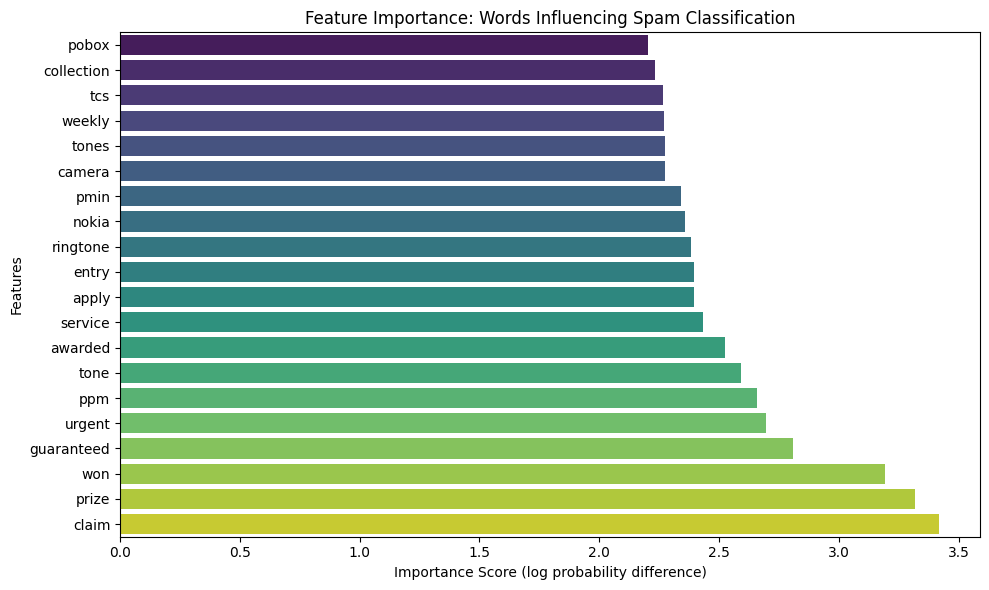

In [16]:
# 📈 Step 14: Feature Importance (based on TF-IDF scores)
import numpy as np

feature_names = vectorizer.get_feature_names_out()

# Difference in log-probability between spam and ham
feature_importance = model.feature_log_prob_[1] - model.feature_log_prob_[0]

# Get top N most influential features (positive = more spammy words)
top_n = 20
top_features_idx = np.argsort(feature_importance)[-top_n:]
top_feature_names = feature_names[top_features_idx]
top_scores = feature_importance[top_features_idx]

# 🔥 Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_scores, y=top_feature_names, palette="viridis")
plt.title("Feature Importance: Words Influencing Spam Classification")
plt.xlabel("Importance Score (log probability difference)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()